In [1]:
#=========================================================================================================
#================================ 0. MODULE

# Classic
import numpy as np
import pandas as pd

# Pytorch framework
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models
from torch.autograd import Function
from torch.autograd import Variable
import torchvision.models as models

# Utils
from typing import List, Tuple
from itertools import product as product
from math import sqrt
from math import pi

# Perso
import sys
from object_detector_Unet import *

device = 'cuda:0'

BATCH_SIZE = 8

Xtrain = np.load('../data/data_train_mini.npy')
Ytrain = pd.read_csv('../data/labels_train_mini.csv').values

priors = PriorCircle(config).forward().to(device)

net = Unet(priors.shape[0]).to(device)

In [16]:
batches = CraterDataset(Xtrain, BATCH_SIZE, Ytrain)
for inputs, idx in batches.loader:
    inputs = Variable(inputs).to(device)
    break

In [17]:
confidence = net(inputs)

In [18]:
inputs.shape

torch.Size([8, 1, 224, 224])

In [19]:
for image_idx in range(inputs.size(0)):

    # Get true craters
    current_label_idx = idx[image_idx]
    true_circles = batches.Ytrain[batches.Ytrain[:, 0] == current_label_idx, 1:4] / 224
    n_true = true_circles.size(0)
    true_circles = Variable(true_circles).to(device)

    # Get prediction
    predicted_conf = confidence[image_idx]
    
    break

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

to_plot = inputs[image_idx].squeeze(0)

tensor([[ 23.0000, 121.0000,   5.7500],
        [ 54.0000, 117.0000,   6.3500],
        [ 33.0000, 108.0000,   9.4000],
        [ 49.0000,  36.0000,   5.8000]], device='cuda:0')

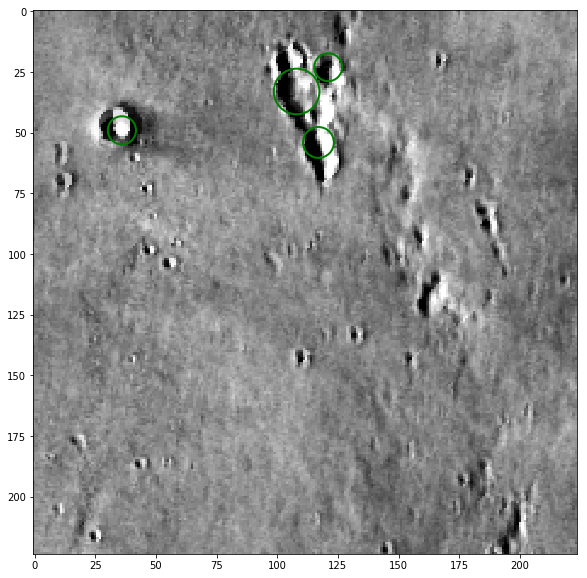

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(to_plot, cmap=plt.cm.gray)

# Draw the true boxes in green
for y, x, r in true_circles * 224:
    ax.add_patch(plt.Circle(
        (x, y), r, color='green', fill=False, linewidth=2))
true_circles * 224

In [22]:
compute_IoU(priors, true_circles)[target == 1]

NameError: name 'target' is not defined

In [23]:
matches = match(priors, true_circles, threshold=0.5)

In [24]:
conf_loss = nn.BCEWithLogitsLoss(reduction='elementwise_mean')

target, _ = matches.max(dim=1)

In [38]:
goal = torch.zeros(target.shape[0]).to(matches.device)
goal[target == 1] = 1

loss = conf_loss(predicted_conf, goal)

In [39]:
loss

tensor(0.6925, device='cuda:0', grad_fn=<MeanBackward1>)

In [37]:
predicted_conf[target == 1] = 1